In [90]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import sklearn.metrics as skmetrics
from sklearn.kernel_ridge import KernelRidge as KernelRidgeRegression
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load, dump
from tqdm.auto import tqdm
import datetime as dt
from google.colab import drive
import os
import itertools

In [91]:
def load_and_prepare_data(features_path, tracks_path,  min_year_bound, max_year_bound, do_bound, group_by = 0):
    """
    Load music features and track metadata; prep for decade classification
    """
    def read_features_file(file_path):
        df = pd.read_csv(file_path, header=[0, 1, 2], low_memory=False)

        df.columns = ['_'.join(str(col) for col in col_tuple if col).strip()
                      for col_tuple in df.columns.values]
        return df

    print("Loading features data...")
    features_df = read_features_file(features_path)

    features_df = features_df.reset_index()
    features_df.rename(columns={'index': 'track_id'}, inplace=True)

    print("Loading tracks data...")
    tracks_df = pd.read_csv(tracks_path, low_memory=False)
    print(tracks_df.head())
    print(tracks_df.columns)

    # first save the first 100 tracks into a separate csv
    tracks_df.head(100).to_csv('data/first_100_tracks.csv', index=False)

    # this is the code for setting genre_top
    if 'track.7' in tracks_df.columns:
        tracks_df['top_genre'] = tracks_df['track.7']

    #this is the code for setting list of genres
    if 'track.9' in tracks_df.columns:
        tracks_df['genres'] = tracks_df['track.9']

    #filter out tracks without date label, create 'date' instead of year column
    if 'album.2' in tracks_df.columns:
        tracks_df['date'] = pd.to_datetime(tracks_df['album.2'], errors='coerce')
    else:
        date_cols = [col for col in tracks_df.columns if 'date_released' in str(col).lower()]
        if date_cols:
            tracks_df['date'] = pd.to_datetime(tracks_df[date_cols[0]], errors='coerce')
        else:
            tracks_df['date'] = pd.to_datetime(tracks_df['track.3'], errors='coerce')

    if 'track_id' not in tracks_df.columns:
        if 'Unnamed: 0' in tracks_df.columns:
            tracks_df = tracks_df[2:].copy()
            tracks_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True)
            tracks_df['track_id'] = pd.to_numeric(tracks_df['track_id'], errors='coerce')

    print(f"tracks_df shape before dropna: {tracks_df.shape}")
    tracks_df = tracks_df.dropna(subset=['track_id'])
    print(f"tracks_df shape after dropna: {tracks_df.shape}")

    #focus range between 2009 and 2013 in order to isolate balanced and robust data set
    if do_bound:
      tracks_df = tracks_df[(tracks_df['date'] >= dt.datetime(min_year_bound, 1, 1)) & (tracks_df['date'] <= dt.datetime(max_year_bound,12,30))]

    features_df['track_id'] = features_df['track_id'].astype(int)
    tracks_df['track_id'] = tracks_df['track_id'].astype(int)

    tracks_df.head(100).to_csv('data/first_100_tracks_filtered.csv', index=False)

    # print("Merging datasets...")
    print(f"Features shape before merge: {features_df.shape}")
    print(f"Tracks shape before merge: {tracks_df.shape}")
    print(f"Feature columns: {features_df.columns[:5]}...")
    print(f"Tracks columns being used: track_id, decade")

    features_df['track_id'] = features_df['track_id'].astype(int)
    tracks_df['track_id'] = tracks_df['track_id'].astype(int)

    merged_df = pd.merge(features_df, tracks_df[['track_id', 'date']],
                         on='track_id', how='inner')

    print(f"Merged dataframe shape: {merged_df.shape}")

    feature_cols = [col for col in merged_df.columns if col != 'track_id' and col != 'date']
    X = merged_df[feature_cols].drop('feature_statistics_number', axis = 1)
    y = merged_df['date']

    print(f"Total samples: {len(X)}")
    print(f"Number of features: {X.shape[1]}")

    return X, y

In [92]:
#connects to my copy of data files

drive.mount('/content/drive/', force_remount=False)
os.chdir('/content/drive/MyDrive/Colab Notebooks/CPSC 381-581: Machine Learning/Final Project')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [93]:
def engineer_music_features(X):
        """Create additional music-specific features"""
        X_new = X.copy()

        chroma_features = [col for col in X.columns if 'chroma' in col.lower()]
        mfcc_features = [col for col in X.columns if 'mfcc' in col.lower()]
        spectral_features = [col for col in X.columns if 'spectral' in col.lower()]

        if len(chroma_features) > 0 and len(mfcc_features) > 0:
            for c_feat in chroma_features[:3]:
                for m_feat in mfcc_features[:3]:
                    X_new[f'ratio_{c_feat}_{m_feat}'] = X[c_feat] / (X[m_feat] + 1e-6)

        if len(mfcc_features) > 0:
            X_new['mfcc_mean'] = X[mfcc_features].mean(axis=1)
            X_new['mfcc_std'] = X[mfcc_features].std(axis=1)

        if len(spectral_features) > 0:
            X_new['spectral_mean'] = X[spectral_features].mean(axis=1)
            X_new['spectral_std'] = X[spectral_features].std(axis=1)

        return X_new

In [94]:
tracks_path = 'fma_metadata/tracks.csv'
features_path = 'fma_metadata/features.csv'

X, y = load_and_prepare_data(features_path, tracks_path, 2009, 2013, do_bound=True)

X_engineered = engineer_music_features(X)

Loading features data...
Loading tracks data...
  Unnamed: 0     album              album.1              album.2   album.3  \
0        NaN  comments         date_created        date_released  engineer   
1   track_id       NaN                  NaN                  NaN       NaN   
2          2         0  2008-11-26 01:44:45  2009-01-05 00:00:00       NaN   
3          3         0  2008-11-26 01:44:45  2009-01-05 00:00:00       NaN   
4          5         0  2008-11-26 01:44:45  2009-01-05 00:00:00       NaN   

     album.4 album.5      album.6  album.7   album.8  ...     track.10  \
0  favorites      id  information  listens  producer  ...  information   
1        NaN     NaN          NaN      NaN       NaN  ...          NaN   
2          4       1      <p></p>     6073       NaN  ...          NaN   
3          4       1      <p></p>     6073       NaN  ...          NaN   
4          4       1      <p></p>     6073       NaN  ...          NaN   

   track.11       track.12            

<ipython-input-91-91dd4b276f9c>:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tracks_df['date'] = pd.to_datetime(tracks_df['album.2'], errors='coerce')


tracks_df shape before dropna: (106574, 56)
tracks_df shape after dropna: (106574, 56)
Features shape before merge: (106575, 520)
Tracks shape before merge: (35839, 56)
Feature columns: Index(['track_id', 'feature_statistics_number', 'chroma_cens_kurtosis_01',
       'chroma_cens_kurtosis_02', 'chroma_cens_kurtosis_03'],
      dtype='object')...
Tracks columns being used: track_id, decade
Merged dataframe shape: (32273, 521)
Total samples: 32273
Number of features: 518


In [95]:
#We are running our KRR on month and year. (Day is too fine-grained). We need to encode each date as a value so we can predict it with a regression.

def encode_year_and_month(date):
  year_centered = date.year - 2009
  mon_num = date.month
  encoded_val = year_centered * 12 + mon_num -1
  return encoded_val


In [96]:
#a function to balance datapoints, so we have an equivalent amount of datapoints for each label

def balance_datapoints(X, y):
  #dataframes to be filled with balanced values
  X = pd.DataFrame(X)

  X_pruned = None
  y_pruned = pd.Series(dtype=int)

  counts = y.value_counts()

  #value to set every count to
  balance_num = min(counts)

  #go through counts and select balance_num of them
  for value_to_balance in counts.index:
    value_indexes = [index for index, val in enumerate(y) if val == value_to_balance]

    X_one_category = X.loc[value_indexes]
    y_one_category = y[value_indexes]

    shuffled_indices = np.random.permutation(len(y_one_category))
    selected_indices = shuffled_indices[:balance_num]

    X_pruned_category = X_one_category.iloc[selected_indices]
    y_pruned_category = y_one_category.iloc[selected_indices]

    if X_pruned is None:
      X_pruned = X_pruned_category
    else:
      X_pruned = pd.concat([X_pruned, X_pruned_category], axis=0)
    y_pruned= pd.concat([y_pruned, y_pruned_category])

  return X_pruned, y_pruned

In [97]:
def seperate_test_train(X, y):
  indexes_random_order = np.random.permutation(X.shape[0])

  X_train = X.iloc[indexes_random_order[:int(len(indexes_random_order) * 0.8)]]
  y_train = y.iloc[indexes_random_order[:int(len(indexes_random_order) * 0.8)]]
  X_test = X.iloc[indexes_random_order[int(len(indexes_random_order) * 0.8):]]
  y_test = y.iloc[indexes_random_order[int(len(indexes_random_order) * 0.8):]]

  return X_train, y_train, X_test, y_test

In [98]:
def run_pca_KRR(X_train, y_train, alpha, gamma, degree, components, kernel):

  #create pipeline
  pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = components)),
    ('krr', KernelRidgeRegression(kernel='rbf', gamma=gamma, degree=degree, alpha=alpha))
  ])

  pipeline.fit(X_train, y_train)

  return pipeline


In [ ]:
def get_test_and_train_error(X, y, alpha, gamma, degree, components, kernel, success_metric):

  #seperate into train and test: 80% train, 20% test
  X_train, y_train, X_test, y_test = seperate_test_train(X,y)

  pipeline = run_pca_KRR(X_train, y_train, alpha, gamma, degree, components, kernel)

  y_hat_test = pipeline.predict(X_test)
  y_hat_train = pipeline.predict(X_train)

  if success_metric == 'mse':
    train_error = skmetrics.mean_squared_error(y_train, y_hat_train)
    test_error = skmetrics.mean_squared_error(y_test, y_hat_test)
  elif success_metric == 'r2':
    train_error = skmetrics.r2_score(y_train, y_hat_train)
    test_error = skmetrics.r2_score(y_test, y_hat_test)
  else:
    raise ValueError('Unsupported metric')

  return train_error, test_error

y_encoded = y.map(encode_year_and_month)

X_bal_eng, y_bal_eng = balance_datapoints(X_engineered, y_encoded)

X_train, y_train, X_test, y_test = seperate_test_train(X_bal_eng, y_bal_eng)

Loading features data...
Loading tracks data...
  Unnamed: 0     album              album.1              album.2   album.3  \
0        NaN  comments         date_created        date_released  engineer   
1   track_id       NaN                  NaN                  NaN       NaN   
2          2         0  2008-11-26 01:44:45  2009-01-05 00:00:00       NaN   
3          3         0  2008-11-26 01:44:45  2009-01-05 00:00:00       NaN   
4          5         0  2008-11-26 01:44:45  2009-01-05 00:00:00       NaN   

     album.4 album.5      album.6  album.7   album.8  ...     track.10  \
0  favorites      id  information  listens  producer  ...  information   
1        NaN     NaN          NaN      NaN       NaN  ...          NaN   
2          4       1      <p></p>     6073       NaN  ...          NaN   
3          4       1      <p></p>     6073       NaN  ...          NaN   
4          4       1      <p></p>     6073       NaN  ...          NaN   

   track.11       track.12            

<ipython-input-91-91dd4b276f9c>:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tracks_df['date'] = pd.to_datetime(tracks_df['album.2'], errors='coerce')


tracks_df shape before dropna: (106574, 56)
tracks_df shape after dropna: (106574, 56)
Features shape before merge: (106575, 520)
Tracks shape before merge: (106574, 56)
Feature columns: Index(['track_id', 'feature_statistics_number', 'chroma_cens_kurtosis_01',
       'chroma_cens_kurtosis_02', 'chroma_cens_kurtosis_03'],
      dtype='object')...
Tracks columns being used: track_id, decade
Merged dataframe shape: (69781, 521)
Total samples: 69781
Number of features: 518


Text(0.5, 1.0, 'Observations Per Year in Dataset')

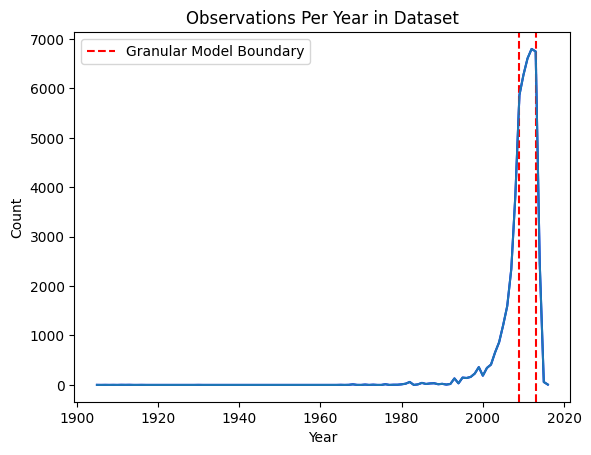

In [99]:
#Graph all observations over time, seperate ours with lines
X_all, y_all = load_and_prepare_data(features_path, tracks_path, 10, 10, False)
def get_year(date):
  return date.year

y_yr = y_all.map(get_year)

counts = y_yr.value_counts().sort_index(ascending = True)

full_years = range(int(min(counts.index)), int(max(counts.index)) + 1)
counts = counts.reindex(full_years, fill_value=0)

graph_df = pd.DataFrame({'Year': range(int(min(counts.index)), int(max(counts.index)+1)),
                         'Count': counts.values
})

ax = sns.lineplot(data=graph_df, x = 'Year', y = 'Count', color = 'blue')

line1 = plt.axvline(x=2009, color='r', linestyle='--', linewidth=1.5, label ='Granular Model Boundary')

plt.axvline(x=2013, color='r', linestyle='--', linewidth=1.5)
ax.legend()

ax = sns.lineplot(data=graph_df, x = 'Year', y = 'Count')
ax.set_title('Observations Per Year in Dataset')

Text(0.5, 1.0, 'Reconstruction MSE vs. Components Preserved for KRR Model Dataset')

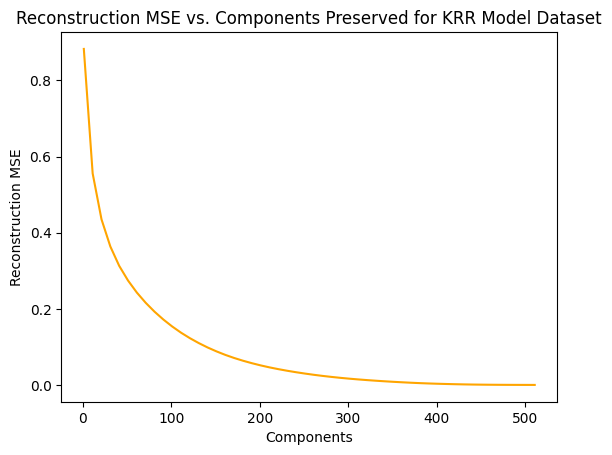

In [100]:
#Look at reconstruction loss for different #s of components. If we decide to balance the data, it will be useful to have fewer features since we will also have fewer data points

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bal_eng)

mse_scores = []

components_to_test = np.arange(1,519, 10)

for components in components_to_test:
  pca_features = PCA(n_components = components)

  pca_features.fit(X_scaled)

  Z = pca_features.transform(X_scaled)

  X_hat = pca_features.inverse_transform(Z)

  mse_score = skmetrics.mean_squared_error(X_scaled, X_hat)

  mse_scores.append(mse_score)

df_graph = pd.DataFrame({
    'Components': components_to_test,
    'Reconstruction MSE': mse_scores
})

ax = sns.lineplot(data=df_graph, x = 'Components', y = 'Reconstruction MSE', color='orange')
ax.set_title('Reconstruction MSE vs. Components Preserved for KRR Model Dataset')

In [101]:
#---------preliminary experiment---------comparing hyperparameter values for KRR----------

best_score = -np.inf
results = []

param_grid = {
          'krr__alpha': [1, 0.1, 1e-2, 1e-4],
          'krr__gamma': [0.1, 0.01, 1e-3, 1e-5],
          'krr__kernel': ['linear', 'rbf', 'polynomial'],
          'krr__degree':[3,4,5],
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 300)),
    ('krr', KernelRidgeRegression())
])

param_combinations = ParameterGrid(param_grid)

with tqdm(total=len(param_combinations), desc="Parameter Combinations") as pbar:
  for i, params in enumerate(param_combinations):
    pipeline.set_params(**params)
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    fit_time = time.time() - start_time

    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)

    results.append({
      'params': params,
      'train_score': train_score,
      'test_score': test_score,
      'fit_time': fit_time
    })

    pbar.set_postfix({
      'alpha': params['krr__alpha'],
      'gamma': params['krr__gamma'],
      'kernel': params['krr__kernel'],
      'degree':params['krr__degree'],
      'train_acc': f"{train_score:.4f}",
      'test_acc': f"{test_score:.4f}",
      'time': f"{fit_time:.2f}s"
    })

    if test_score > best_score:
      best_score = test_score
      best_params = params
      best_model = pipeline

    pbar.update(1)

print("\nGrid search results summary:")
results_df = pd.DataFrame([
  {
  'alpha': r['params']['krr__alpha'],
  'gamma': r['params']['krr__gamma'],
  'kernel': r['params']['krr__kernel'],
  'degree': r['params']['krr__degree'],
  'train_score': r['train_score'],
  'test_score': r['test_score'],
  'fit_time': r['fit_time']
  }
  for r in results
])

print(results_df.sort_values('test_score', ascending=False).head(5))
print("\nBest parameters:", best_params)

Parameter Combinations:   0%|          | 0/144 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [53]:
#look at table results
print(results_df.sort_values('test_score', ascending=False).head(20))

#get MSE values for best results (see table in project)
print("Top result 1: Train MSE: {}. Test MSE: {}".format(*get_test_and_train_error(X_bal_eng, y_bal_eng, alpha = 1, gamma = 0.001, degree = 0, components = 300, kernel = 'rbf', success_metric = 'mse')))
print("Top result 2: Train MSE: {}. Test MSE: {}".format(*get_test_and_train_error(X_bal_eng, y_bal_eng, alpha = 0.1, gamma = 0.001, degree = 0, components = 300, kernel = 'rbf', success_metric = 'mse')))
print("Top result 3: Train MSE: {}. Test MSE: {}".format(*get_test_and_train_error(X_bal_eng, y_bal_eng, alpha = 0.1, gamma = 0.00001, degree = 0, components = 300, kernel = 'rbf', success_metric = 'mse')))
print("Top result 4: Train MSE: {}. Test MSE: {}".format(*get_test_and_train_error(X_bal_eng, y_bal_eng, alpha = 0.1, gamma = 0.00001, degree = 5, components = 300, kernel = 'polynomial', success_metric = 'mse')))
print("Top result 4: Train MSE: {}. Test MSE: {}".format(*get_test_and_train_error(X_bal_eng, y_bal_eng, alpha = 0.1, gamma = 0.00001, degree = 4, components = 300, kernel = 'polynomial', success_metric = 'mse')))


    alpha    gamma      kernel  degree  train_score  test_score   fit_time
7    1.00  0.00100         rbf       3     0.257937    0.056734  12.680993
19   1.00  0.00100         rbf       4     0.257937    0.056734  10.749167
31   1.00  0.00100         rbf       5     0.257937    0.056734  12.618029
43   0.10  0.00100         rbf       3     0.628695    0.036864  10.671597
55   0.10  0.00100         rbf       4     0.628695    0.036864  12.777067
67   0.10  0.00100         rbf       5     0.628695    0.036864  10.663269
70   0.10  0.00001         rbf       5     0.066597    0.036305  10.661598
58   0.10  0.00001         rbf       4     0.066597    0.036305  12.722034
46   0.10  0.00001         rbf       3     0.066597    0.036305  10.638639
35   1.00  0.00001  polynomial       5     0.054817    0.034881  13.088325
23   1.00  0.00001  polynomial       4     0.052015    0.034660  11.213444
47   0.10  0.00001  polynomial       3     0.069559    0.034419  11.150904
59   0.10  0.00001  polyn

In [102]:
#experiment #1-------------playing with gamma values------------------------

POTENTIAL_GAMMAS = [0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

gamma_mses_test = []
gamma_mses_train = []


for gamma in POTENTIAL_GAMMAS:
  train_mse, test_mse = get_test_and_train_error(X_bal_eng, y_bal_eng, alpha  = 1, gamma = gamma, degree = 0, components = 300, kernel ='rbf', success_metric = 'mse')
  gamma_mses_test.append(test_mse)
  gamma_mses_train.append(train_mse)
  print("Finished! {}".format(gamma))

Finished! 0.5
Finished! 0.1
Finished! 0.01
Finished! 0.001
Finished! 0.0001
Finished! 1e-05
Finished! 1e-06


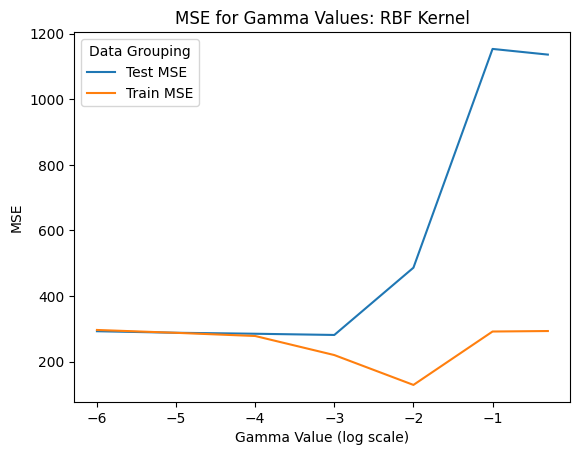

In [103]:
graph_df = pd.DataFrame({'Gamma Value': np.log10(POTENTIAL_GAMMAS),
                         'Test MSE':gamma_mses_test,
                         'Train MSE': gamma_mses_train})
graph_df_long = pd.melt(graph_df, id_vars = 'Gamma Value', var_name = 'Data Grouping', value_name='MSE')


ax = sns.lineplot(data = graph_df_long, x = 'Gamma Value', y = 'MSE', hue = 'Data Grouping')
ax.set_title('MSE for Gamma Values: RBF Kernel')
ax.set_xlabel('Gamma Value (log scale)')
plt.show()

In [104]:
#experiment #2---------------why does low gamma do better?------------------------------

pipeline_gamma_small = run_pca_KRR(X_train, y_train, degree = 0, components = 300, kernel = 'rbf', gamma = 0.01, alpha = 1)
pipeline_gamma_smaller = run_pca_KRR(X_train, y_train, degree = 0, components = 300, kernel = 'rbf', gamma = 0.0001, alpha = 0.1)


Text(0.5, 1.0, 'Guess Counts For Top RBF KRR Models For 2009 to 2013')

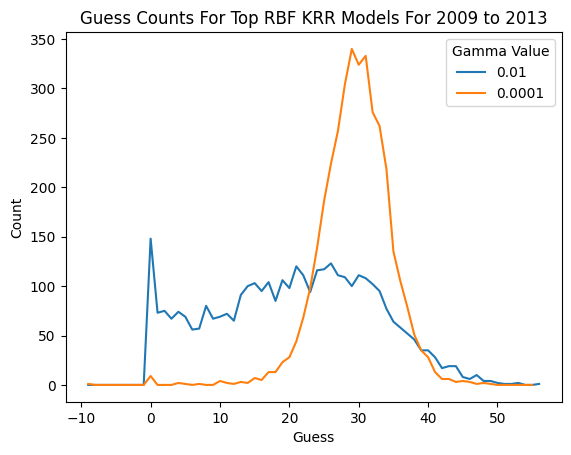

In [105]:
y_hat_small = pipeline_gamma_small.predict(X_test)
y_hat_smaller = pipeline_gamma_smaller.predict(X_test)

def generate_values_count(y_hat):
  values_collapsed = pd.Series(y_hat).map(np.round).value_counts()
  values_collapsed = values_collapsed.sort_index()
  return values_collapsed

values_count_small = generate_values_count(y_hat_small)
values_count_smaller = generate_values_count(y_hat_smaller)

guesses_min = int(min(values_count_small.index.min(), values_count_smaller.index.min()))
guesses_max = int(max(values_count_small.index.max(), values_count_smaller.index.max()))

#fill gaps to prevent errors
for value in range(guesses_min, guesses_max):
  for list in [values_count_small, values_count_smaller]:
    if not value in list.index:
      list[value] = 0

graph_df = pd.DataFrame({'Guess': range(guesses_min, guesses_max+1),
                         '0.01': values_count_small,
                         '0.0001': values_count_smaller
})

graph_df_long = pd.melt(graph_df, id_vars = 'Guess', var_name = 'Gamma Value', value_name='Count')


ax = sns.lineplot(data=graph_df_long, x = 'Guess', y = 'Count', hue = 'Gamma Value')
ax.set_title('Guess Counts For Top RBF KRR Models For 2009 to 2013')